In [1]:
import subprocess
import os
import time
import gc

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt 

from od_perturber import od_perturber
from output_reader import output_reader

This is written to be run on a **Linux** machine. First pass evaluations are done on the Sioux Falls network for speed and per standard.

# Automate TSTT calculation for an individual OD matrix perturbation

In [2]:
def tap_trial(
            netFileName,
            demandFileName, 
            perturbType="normal", 
            norm_mean=1, 
            norm_sd=.1, 
            uniform_low=.9, 
            uniform_high=1.1,
            nodesPerturbedAlways=[],
            nodesPerturbedIfOrig=[],
            nodesPerturbedIfDest=[],
            returnDataFrame=False
):
    '''
    Generate a new TSTT calculation for a specific network, trip demands, and perturbation combination.
    '''
    od = od_perturber(
        demandFileName, 
        perturbType, 
        norm_mean, 
        norm_sd, 
        uniform_low, 
        uniform_high,
        nodesPerturbedAlways,
        nodesPerturbedIfOrig,
        nodesPerturbedIfDest
    )
    subprocess.run("tap-b/bin/tap " + netFileName + " trips_perturbed.tntp >/dev/null", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL);
    if returnDataFrame:
        return output_reader("full_log.txt", netFileName)
    else:
        _,tstt,congestion = output_reader("full_log.txt", netFileName)
        return tstt,congestion

df, true_tstt, true_wvc = tap_trial("SiouxFalls_net.tntp", "SiouxFalls_trips.tntp", norm_mean=1, norm_sd=0, returnDataFrame=True)
true_tstt, true_wvc

(7480171.248174683, 0.0193951334707874)

In [3]:
df.head()

,flow,cost,der,capacity
link,,,,
"(1,2)",4494.611949,6.000816,0.000001,25900.200640
"(1,3)",8119.023795,4.008691,0.000004,23403.473190
"(2,1)",4519.023795,6.000834,0.000001,25900.200640
"(2,6)",5967.349609,6.573612,0.001055,4958.180928
"(3,1)",8094.611949,4.008586,0.000004,23403.473190


In [4]:
del df

# Examine runtime of different networks

Candidate networks need to have node coordinates and run relatively quickly.

In [5]:
networks = [
#     'berlin-center',
    'friedrichshain-center',
    'berlin-mitte-center',
    'berlin-mitte-prenzlauerberg-friedrichshain-center',
    'berlin-prenzlauerberg-center',
    'berlin-tiergarten',
#     'Birmingham',
#     'ChicagoSketch',
#     'Philadelphia',
    'SiouxFalls',
#     'ChicagoRegional'
]

tap_times = {}
for net in networks:
    print(net)
    start = time.time()
    try:
        tstt, _ = tap_trial('inputs/{}_net.tntp'.format(net), 'inputs/{}_trips.tntp'.format(net), norm_mean=1, norm_sd=0)
        if tstt == 0:
            print('TAP ISSUE with', net)
            tap_times[net] = np.nan
        else:
            tap_times[net] = time.time()-start
            print(tstt)
        print('')
        del tstt
    except OSError:
        print('MEMORY ISSUE with', net)
        tap_times[net] = np.nan
    gc.collect()
tap_times

friedrichshain-center
728609.3041808964

berlin-mitte-center
1051175.476303525

berlin-mitte-prenzlauerberg-friedrichshain-center
2362496.7296204716

berlin-prenzlauerberg-center
1399925.458516812

berlin-tiergarten
716823.6964993115

SiouxFalls
7480171.248174683



{'friedrichshain-center': 0.41438961029052734,
 'berlin-mitte-center': 0.6391196250915527,
 'berlin-mitte-prenzlauerberg-friedrichshain-center': 2.2236685752868652,
 'berlin-prenzlauerberg-center': 0.6535181999206543,
 'berlin-tiergarten': 0.5174942016601562,
 'SiouxFalls': 0.08026361465454102}

# Analyze a specific network

## Scale iterations to match and find unperturbed ("true") network metrics.

In [6]:
net = 'friedrichshain-center'
#     'berlin-center'
#     'friedrichshain-center'
#     'berlin-mitte-center'
#     'berlin-mitte-prenzlauerberg-friedrichshain-center'
#     'berlin-prenzlauerberg-center'
#     'berlin-tiergarten'
#     'SiouxFalls'

netFilename = 'inputs/{}_net.tntp'.format(net)
tripsFilename = 'inputs/{}_trips.tntp'.format(net)
    
n = 500
if tap_times[net] > 1:
    n = 40
elif tap_times[net] > .5:
    n = 100
elif tap_times[net] > .25:
    n = 200

true_tstt, true_wvc = tap_trial(netFilename, tripsFilename, norm_mean=1, norm_sd=0, returnDataFrame=False)
true_tstt, true_wvc

(728609.3041808964, 0.0007211546334550366)

## Run trials for several perturbation mean and standard deviation combinations

(Except N(1,0) perturbations, since they only need one trial each.)

Avoid redoing the sampling by reading from a pre-exported csv. If it doesn't exist, then run the trials.

In [7]:
def track_ci_width_evo(netFilename, tripsFilename, n=1000):
    if n<=30:
        raise ValueError('Sample size needs to be greater than 30.')
    
    means = np.arange(0.25, 2, .25)
    sds = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

    results = {}

    for mean in means:
        results[mean] = {}
        for sd in sds:
            results[mean][sd] = {
                'tstts': np.zeros(n)*np.nan,
                'wvcs': np.zeros(n)*np.nan,
                'tstt_widths': np.zeros(n)*np.nan,
                'wvc_widths': np.zeros(n)*np.nan
            }
            for i in range(n):
                results[mean][sd]['tstts'][i], results[mean][sd]['wvcs'][i] = tap_trial(netFilename, tripsFilename, norm_mean=mean, norm_sd=sd, returnDataFrame=False)
                results[mean][sd]['tstt_widths'][i] = 4*results[mean][sd]['tstts'][0:i+1].std()
                results[mean][sd]['wvc_widths'][i] = 4*results[mean][sd]['wvcs'][0:i+1].std()
    
    # format the results into a DataFrame for easy queryign and csv export
    df_trials = pd.DataFrame(columns=['mean', 'sd', 'tstt', 'congestion'])
    df_ci_evo = pd.DataFrame(columns=['mean', 'sd', 'n', 'tstt_ci_width', 'congestion_ci_width'])
    for mean in results:
        for sd in results[mean]:
            df_trials = pd.concat([df_trials, pd.DataFrame({
                'mean': np.ones(n)*mean,
                'sd': np.ones(n)*sd,
                'tstt': results[mean][sd]['tstts'],
                'congestion': results[mean][sd]['wvcs']
            })], ignore_index=True)
            df_ci_evo = pd.concat([df_ci_evo, pd.DataFrame({
                'mean': np.ones(n)*mean,
                'sd': np.ones(n)*sd,
                'n': range(n),
                'tstt_ci_width': results[mean][sd]['tstt_widths'],
                'congestion_ci_width': results[mean][sd]['wvc_widths']
            })], ignore_index=True)
    df_trials.to_csv('output/{}_trials.csv'.format(net), index=False)
    df_ci_evo.to_csv('output/{}_ci_evo.csv'.format(net), index=False)
    return df_trials, df_ci_evo

try:
    df_trials = pd.read_csv('output/{}_trials.csv'.format(net))
    df_ci_evo = pd.read_csv('output/{}_ci_evo.csv'.format(net))
except FileNotFoundError:
    df_trials, df_ci_evo = track_ci_width_evo(netFilename, tripsFilename, n=n)
df_trials.head()

,mean,sd,tstt,congestion
0,0.25,0.001,142164.368772,0.000259
1,0.25,0.001,142133.161695,0.000259
2,0.25,0.001,142120.062624,0.000259
3,0.25,0.001,142120.002118,0.000259
4,0.25,0.001,142176.916753,0.000259


## Examine evolution of confidence interval width for increasing sample sizes

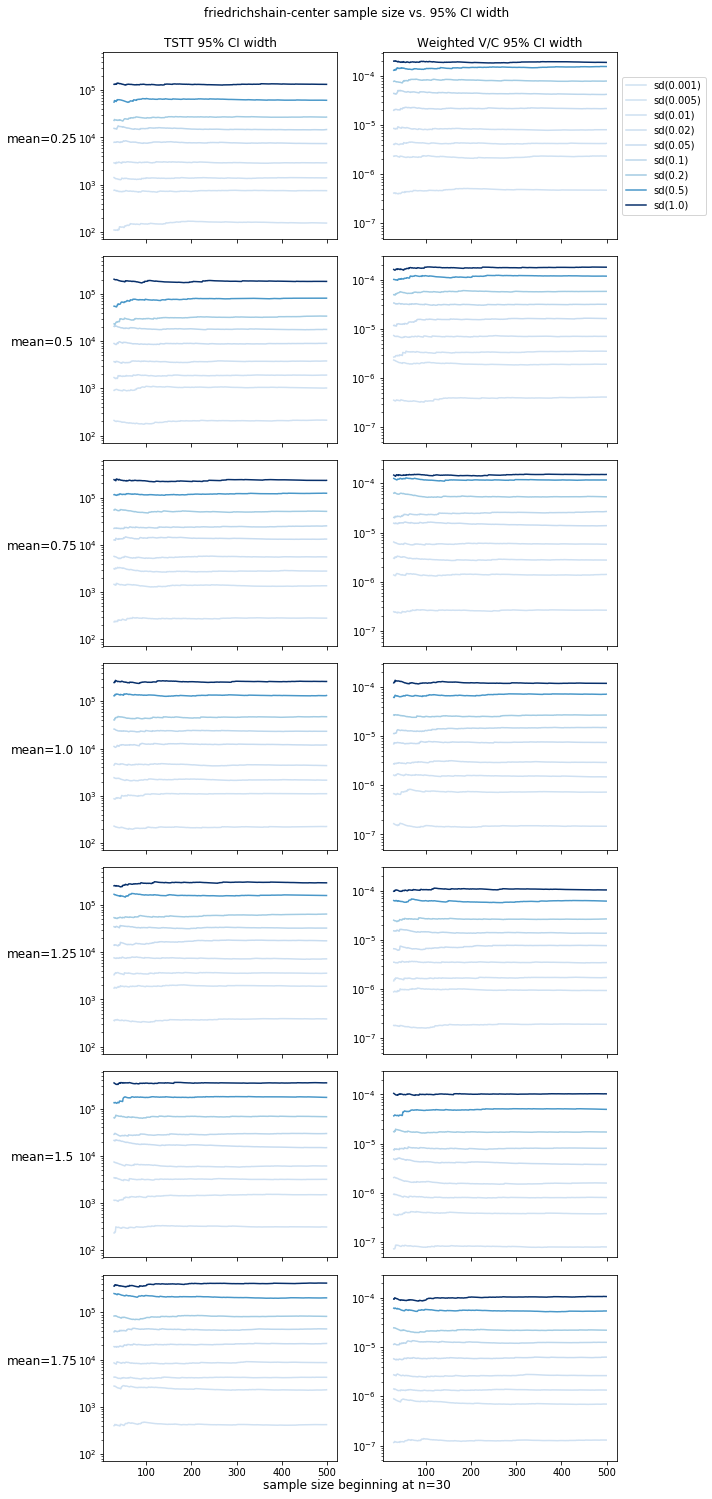

In [8]:
def plot_ci_width_evo(df_ci_evo, net, plotFilename=None):
    n = df_ci_evo['n'].max()+1
    if n<=30:
        raise ValueError('Sample size needs to be greater than 30.')
    
    means = df_ci_evo['mean'].unique()
    means.sort()
    sds = df_ci_evo['sd'].unique()
    sds.sort()

    Blues = plt.get_cmap('Blues')

    fig, axes = plt.subplots(nrows=len(means), ncols=2, sharex=True, sharey='col', figsize=(10,len(means)*3))
    x = range(29,n)
    axes[0][0].set_title('TSTT 95% CI width')
    axes[0][1].set_title('Weighted V/C 95% CI width')
    for i,mean in enumerate(means):
        for sd in sds:
            color = 1-(1-sd)/1.25
            dftemp = df_ci_evo[(df_ci_evo['mean']==mean) & (df_ci_evo['sd']==sd)]
            axes[i][0].plot(x, dftemp['tstt_ci_width'][29:], c=Blues(color), label='sd({})'.format(sd))
            axes[i][1].plot(x, dftemp['congestion_ci_width'][29:], c=Blues(color), label='sd({})'.format(sd))
            axes[i][0].set_yscale('log')
            axes[i][1].set_yscale('log')
        axes[i][0].set_ylabel('mean={}'.format(round(mean,2)), rotation=0, size='large', labelpad = 35)
    axes[0][1].legend(loc='center left', bbox_to_anchor=(1,0.5))
    fig.suptitle('{} sample size vs. 95% CI width'.format(net))
    fig.text(0.5, 0, 'sample size beginning at n=30', ha='center', fontsize=12)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    if plotFilename:
        plt.savefig(plotFilename, dpi='figure')
    plt.show()

plot_ci_width_evo(df_ci_evo, net, plotFilename='output/{}_widths.png'.format(net))

## Compare results for different means

In [9]:
means = np.arange(0,2,.25)
reses = [tap_trial(netFilename, tripsFilename, norm_mean=mean, norm_sd=0, returnDataFrame=False) for mean in means]
tstts_scaled = np.array([r[0] for r in reses])/true_tstt
congestions = [r[1] for r in reses]

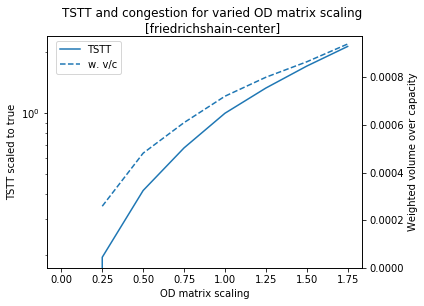

In [10]:
def tstt_wvc_plot(inputs, tstts, congestions, input_name, net, log_input=False, log_tstt=False, output_fig_name=None):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel(input_name)
    ax1.set_ylabel('TSTT scaled to true')
    ax1.plot(inputs, tstts, label='TSTT')
    if log_input:
        ax1.set_xscale('log')
    if log_tstt:
        ax1.set_yscale('log')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Weighted volume over capacity')
    ax2.plot(inputs, congestions, linestyle='--', label='w. v/c')
    ax2.set_ylim(bottom=0)

    fig.legend(loc=1, bbox_to_anchor=(0.25,1), bbox_transform=ax1.transAxes)
    fig.suptitle('TSTT and congestion for varied {}\n[{}]'.format(input_name,net), y=1.05)
    fig.tight_layout()
    if output_fig_name:
        plt.savefig(output_fig_name, dpi='figure')
    plt.show()

tstt_wvc_plot(means, tstts_scaled, congestions, 'OD matrix scaling', net, log_tstt=True, output_fig_name='output/{}_mean_scaling.png'.format(net))

## Compare results for different standard deviations

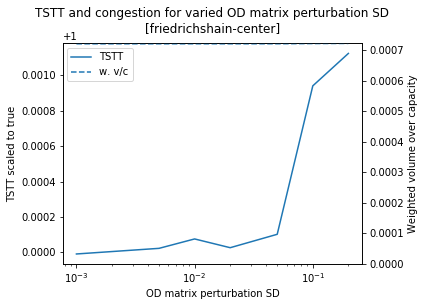

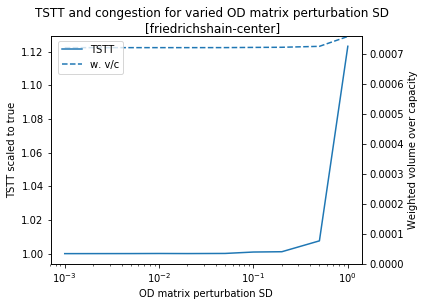

In [11]:
sds = df_trials['sd'].unique()
sds.sort()
tstts_scaled = np.array([df_trials[(df_trials['mean']==1) & (df_trials['sd']==sd)]['tstt'].mean() for sd in sds])/true_tstt
congestions = np.array([df_trials[(df_trials['mean']==1) & (df_trials['sd']==sd)]['congestion'].mean() for sd in sds])
tstt_wvc_plot(sds[:-2], tstts_scaled[:-2], congestions[:-2], 'OD matrix perturbation SD', net, log_input=True, output_fig_name='output/{}_stdv_scaling.png'.format(net))
tstt_wvc_plot(sds, tstts_scaled, congestions, 'OD matrix perturbation SD', net, log_input=True, output_fig_name='output/{}_stdv_scaling.png'.format(net))

### Visualize TSTT from many trials

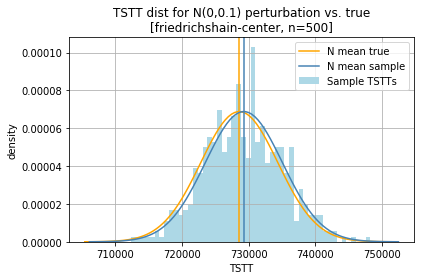

  true mean: 728609.3041808964
sample mean: 729295.2581105654
sample stdv: 5792.702438055919


In [12]:
def visualize(tstts, mean_true, plot_true_mean=True, img_title=None, img_filename=None, verbose_output=False):
    mean_sample = tstts.mean()
    sd = tstts.std()
    xsnorm = np.linspace(mean_sample - 4*sd, mean_sample + 4*sd, 100)
    xtnorm = np.linspace(mean_true - 4*sd, mean_true + 4*sd, 100)

    tstts.hist(bins=min([len(tstts)//10,100]), label='Sample TSTTs', color='lightblue', density=True)
    if plot_true_mean:
        plt.axvline(x=mean_true, color='orange')
        plt.plot(xtnorm, stats.norm.pdf(xtnorm, mean_true, sd), color='orange', label='N mean true')
    plt.axvline(x=mean_sample, color='steelblue')
    plt.plot(xsnorm, stats.norm.pdf(xsnorm, mean_sample, sd), color='steelblue', label='N mean sample')
    
    if img_title:
        plt.title(img_title)
    plt.ylabel('density')
    plt.xlabel('TSTT')
    plt.legend()
    plt.tight_layout()
    if img_filename:
        plt.savefig(img_filename, dpi='figure')
    plt.show()
    
    if verbose_output:
        print('  true mean:', mean_true)
        print('sample mean:', mean_sample)
        print('sample stdv:', sd)
    
    return mean_sample, sd

n1sdp1_mean, n1sdp1_sd = visualize(df_trials.loc[(df_trials['mean']==1) & (df_trials['sd']==0.1),'tstt'], true_tstt, 
                                   img_title='TSTT dist for N({},{}) perturbation vs. true\n[{}, n={}]'.format(0, 0.1, net, n), 
                                   img_filename='output/{}_normcompare.png'.format(net), verbose_output=True)

## Monte Carlo simulations

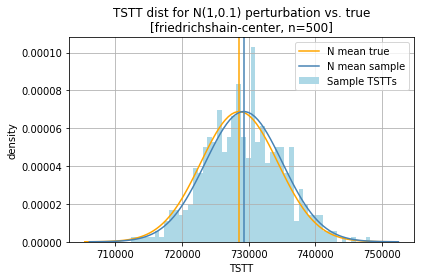

  true mean: 728609.3041808964
sample mean: 729295.2581105654
sample stdv: 5792.702438055919
  shapiro p: 0.9974663257598877
% in 95% CI: 0.958



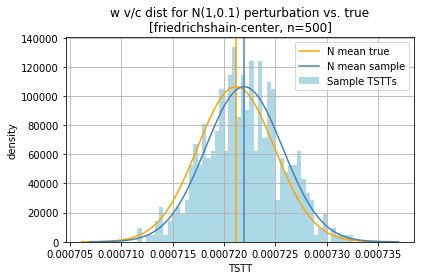

  true mean: 0.0007211546334550366
sample mean: 0.0007219495622673706
sample stdv: 3.747597930790848e-06
  shapiro p: 0.844470739364624
% in 95% CI: 0.954


In [13]:
def test_perturbation_pair(
    df,
    
    norm_mean,
    norm_sd,
    
    tstt_true,
    wvc_true,
    
    net_name=None,
    plot_true_mean=True,
    verbose_output=False,
    
    return_sample=False
):
    
    dft = df.loc[np.isclose(df_trials['mean'],norm_mean) & np.isclose(df_trials['sd'],norm_sd)]
    n = len(dft)
    
    tstts = dft['tstt']
    tstt_mean, tstt_sd = visualize(tstts, tstt_true, plot_true_mean, 
                                   img_title='TSTT dist for N({},{}) perturbation vs. true\n[{}, n={}]'.format(norm_mean, norm_sd, net_name, n), 
                                   img_filename='output/{}_tstt_N({},{})_n{}.png'.format(net_name, norm_mean, norm_sd, n), verbose_output=verbose_output)
    tstt_pvalue = stats.shapiro(tstts)[1]
    if verbose_output:
        print('  shapiro p:', tstt_pvalue)
        print('% in 95% CI:', ((tstts > tstt_mean-2*tstt_sd) & (tstts < tstt_mean+2*tstt_sd)).sum()/len(tstts))
    
    print('')
    wvcs = dft['congestion']
    wvc_mean, wvc_sd = visualize(wvcs, wvc_true, plot_true_mean, 
                                 img_title='w v/c dist for N({},{}) perturbation vs. true\n[{}, n={}]'.format(norm_mean, norm_sd, net_name, n), 
                                 img_filename='output/{}_wvc_N({},{})_n{}.png'.format(net_name, norm_mean, norm_sd, n), verbose_output=verbose_output)
    wvc_pvalue = stats.shapiro(wvcs)[1]
    if verbose_output:
        print('  shapiro p:', wvc_pvalue)
        print('% in 95% CI:', ((wvcs > wvc_mean-2*wvc_sd) & (wvcs < wvc_mean+2*wvc_sd)).sum()/len(wvcs))
    
    return tstt_mean, tstt_sd, tstt_pvalue, wvc_mean, wvc_sd, wvc_pvalue

n1sdp1_tstt_mn, n1sdp1_tstt_sd, n1sdp1_tstt_p, n1sdp1_wvc_mn, n1sdp1_wvc_sd, n1sdp1_wvc_p = test_perturbation_pair(df_trials,
                                                                                                                     1, 0.1,
                                                                                                                     true_tstt, true_wvc,
                                                                                                                     net_name=net,
                                                                                                                     verbose_output=True,
                                                                                                                     return_sample=True)

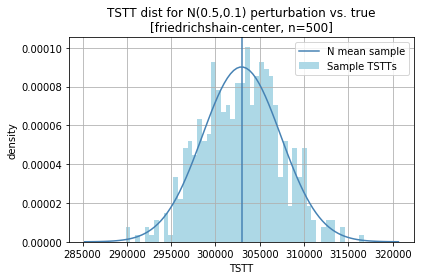

  true mean: 728609.3041808964
sample mean: 302948.02112624905
sample stdv: 4425.594529228734
  shapiro p: 0.64107346534729
% in 95% CI: 0.96



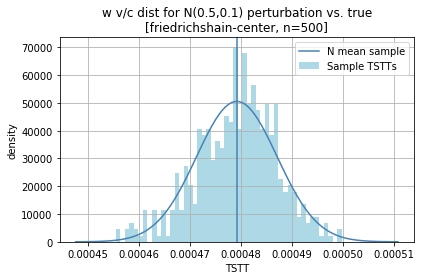

  true mean: 0.0007211546334550366
sample mean: 0.0004791576209283459
sample stdv: 7.88900881089806e-06
  shapiro p: 0.005523651372641325
% in 95% CI: 0.948


In [14]:
np5sdp1_tstt_mean, np5sdp1_tstt_sd, np5sdp1_tstt_pv, np5sdp1_wvc_mean, np5sdp1_wvc_sd, np5sdp1_wvc_pv = test_perturbation_pair(df_trials,
                                                                                                                             0.5, 0.1,
                                                                                                                             true_tstt, true_wvc,
                                                                                                                             net_name=net,
                                                                                                                             plot_true_mean=False,
                                                                                                                             verbose_output=True)

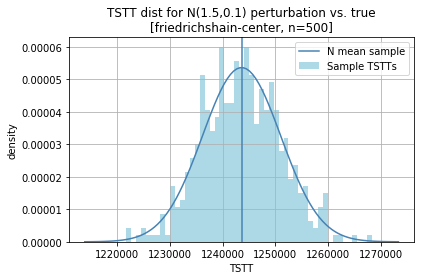

  true mean: 728609.3041808964
sample mean: 1243599.9222425937
sample stdv: 7440.680181612414
  shapiro p: 0.9502894878387451
% in 95% CI: 0.954



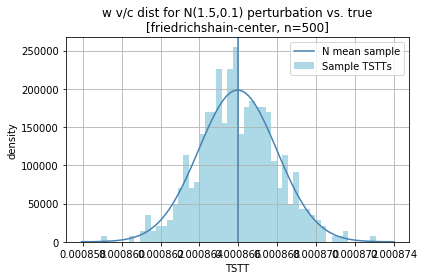

  true mean: 0.0007211546334550366
sample mean: 0.0008659676473849782
sample stdv: 2.010255651187523e-06
  shapiro p: 0.9408408999443054
% in 95% CI: 0.95


In [15]:
n1p5sdp1_tstt_mean, n1p5sdp1_tstt_sd, n1p5sdp1_tstt_pv, n1p5sdp1_wvc_mean, n1p5sdp1_wvc_sd, n1p5sdp1_wvc_pv = test_perturbation_pair(df_trials,
                                                                                                                                     1.5, 0.1,
                                                                                                                                     true_tstt, true_wvc,
                                                                                                                                     net_name=net,
                                                                                                                                     plot_true_mean=False,
                                                                                                                                     verbose_output=True)

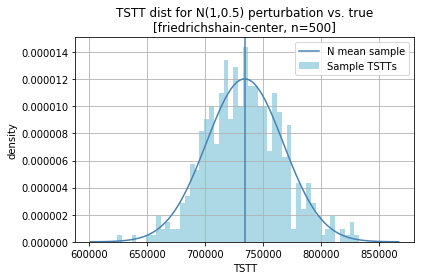

  true mean: 728609.3041808964
sample mean: 734135.5983664282
sample stdv: 33162.05513396299
  shapiro p: 0.4323197603225708
% in 95% CI: 0.948



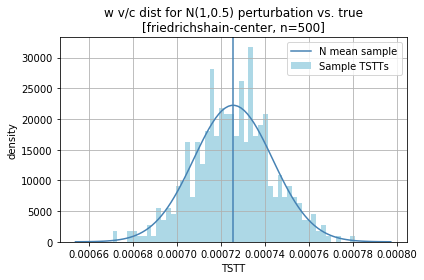

  true mean: 0.0007211546334550366
sample mean: 0.0007255100858075863
sample stdv: 1.7930223917478783e-05
  shapiro p: 0.9515826106071472
% in 95% CI: 0.952


In [16]:
n1sdp5_tstt_mean, n1sdp5_tstt_sd, n1sdp5_tstt_pv, n1sdp5_wvc_mean, n1sdp5_wvc_sd, n1sdp5_wvc_pv = test_perturbation_pair(df_trials,
                                                                                                                         1, 0.5,
                                                                                                                         true_tstt, true_wvc,
                                                                                                                         net_name=net,
                                                                                                                         plot_true_mean=False,
                                                                                                                         verbose_output=True)